In [ ]:
import os
from scipy.io import wavfile
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

from scipy import spatial

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

class readAudio():
    def __init__(self, mix_dir, src_dir, logscale, device):
        self.mix_dir = mix_dir
        self.src_dir = src_dir
        self.mixture = os.listdir(mix_dir)
        self.logscale = logscale
        self.device = device
        
    def __len__(self):
        return len(self.mixture)
    
    def __getitem__(self, num_sets, chunk_size):
        if self.logscale == True:
            print('READING AUDIOS in LOGSCALE')
        if self.logscale == False:
            print('READING AUDIOS not in LOGSCALE')

        output_arr = []
        max_arr = []
        
        # index = num_sets
        for index in range(num_sets):
            if index == 0:
                print(index)
                mix_path    = os.path.join(self.mix_dir, self.mixture[index]) + '/mixture.wav'
                bass_path   = os.path.join(self.src_dir, self.mixture[index]) + '/bass.wav'
                drums_path  = os.path.join(self.src_dir, self.mixture[index]) + '/drums.wav'
                vocals_path = os.path.join(self.src_dir, self.mixture[index]) + '/vocals.wav'
                other_path = os.path.join(self.src_dir, self.mixture[index]) + '/other.wav'
                # print(mix_path)
                fs_mix,    data_mix    = wavfile.read(mix_path)
                fs_bass,   data_bass   = wavfile.read(bass_path)
                fs_drums,  data_drums  = wavfile.read(drums_path)
                fs_vocals, data_vocals = wavfile.read(vocals_path)
                fs_other, data_other = wavfile.read(other_path)

                out_l_mix_uncut = data_mix[:, 0].astype(float)
                out_l_bass_uncut = data_bass[:, 0].astype(float)
                out_l_drums_uncut = data_drums[:, 0].astype(float)
                out_l_vocals_uncut = data_vocals[:, 0].astype(float)
                out_l_other_uncut = data_other[:, 0].astype(float)
                out_r_mix_uncut = data_mix[:, 1].astype(float)
                out_r_bass_uncut = data_bass[:, 1].astype(float)
                out_r_drums_uncut = data_drums[:, 1].astype(float)
                out_r_vocals_uncut = data_vocals[:, 1].astype(float)
                out_r_other_uncut = data_other[:, 1].astype(float)

                print('mix len: ', len(out_l_mix_uncut))
                
                #29032023(start)
                mix_l_sum = np.empty(0) #29032023
                for start in range(0, len(out_l_mix_uncut), chunk_size): # real
                    end = start + chunk_size
                    out_l_mix = torch.from_numpy(out_l_mix_uncut[start:end])
                    out_l_mix_sum = torch.sum(torch.abs(out_l_mix))#29032023
                    mix_l_sum = np.append(mix_l_sum, out_l_mix_sum)#29032023

                
                mix_l_sum_counts, mix_l_sum_bins = np.histogram(mix_l_sum)
                mix_l_sum_xmin = [np.mean(mix_l_sum) - 1.5*np.std(mix_l_sum), np.mean(mix_l_sum) - 1.5*np.std(mix_l_sum)]
                mix_l_sum_xmax = [np.mean(mix_l_sum) + 1.5*np.std(mix_l_sum), np.mean(mix_l_sum) + 1.5*np.std(mix_l_sum)]
                nearIdx_min_mix_l_sum = find_nearest(mix_l_sum_bins, value=np.mean(mix_l_sum) - 1.5*np.std(mix_l_sum))
                nearIdx_max_mix_l_sum = find_nearest(mix_l_sum_bins, value=np.mean(mix_l_sum) + 1.5*np.std(mix_l_sum))
                crucial_count_mix_l_sum = np.sum(mix_l_sum_counts[nearIdx_min_mix_l_sum:nearIdx_max_mix_l_sum])
                #29032023(finish)

                
                # mix_l_sum = np.empty(0) #29032023
                for start in range(0, len(out_l_mix_uncut), chunk_size): # real
                    # print(start, "/", len(out_l_mix_uncut))
                # for start in range(0, chunk_size*2, chunk_size): # real
                # for start in range(1000000,1001001): # debug
                    end = start + chunk_size

                    # They can be just numpy. That still works
                    out_l_mix = torch.from_numpy(out_l_mix_uncut[start:end])
                    out_l_bass = torch.from_numpy(out_l_bass_uncut[start:end])
                    out_l_drums = torch.from_numpy(out_l_drums_uncut[start:end])
                    out_l_vocals = torch.from_numpy(out_l_vocals_uncut[start:end])
                    out_l_other = torch.from_numpy(out_l_other_uncut[start:end])
                    out_r_mix = torch.from_numpy(out_r_mix_uncut[start:end])
                    out_r_bass = torch.from_numpy(out_r_bass_uncut[start:end])
                    out_r_drums = torch.from_numpy(out_r_drums_uncut[start:end])
                    out_r_vocals = torch.from_numpy(out_r_vocals_uncut[start:end])
                    out_r_other = torch.from_numpy(out_r_other_uncut[start:end])
                    
                    out_l_vo = out_l_vocals+out_l_other
                    out_r_vo = out_r_vocals+out_l_other
                    
                    out_l_mix_sum = torch.sum(torch.abs(out_l_mix))#29032023
                    # mix_l_sum = np.append(mix_l_sum, out_l_mix_sum)#29032023

                    if self.logscale == True:
                        out_l_mix = torch.sign(out_l_mix) * torch.log10(torch.abs(out_l_mix))
                        out_l_bass=torch.sign(out_l_bass) * torch.log10(torch.abs(out_l_bass))
                        out_l_drums=torch.sign(out_l_drums) * torch.log10(torch.abs(out_l_drums))
                        out_l_vocals=torch.sign(out_l_vocals) * torch.log10(torch.abs(out_l_vocals))
                        out_l_other=torch.sign(out_l_other) * torch.log10(torch.abs(out_l_other))
                        out_r_mix=torch.sign(out_r_mix) * torch.log10(torch.abs(out_r_mix))
                        out_r_bass=torch.sign(out_r_bass) * torch.log10(torch.abs(out_r_bass))
                        out_r_drums=torch.sign(out_r_drums) * torch.log10(torch.abs(out_r_drums))
                        out_r_vocals=torch.sign(out_r_vocals) * torch.log10(torch.abs(out_r_vocals))
                        out_r_other=torch.sign(out_r_other) * torch.log10(torch.abs(out_r_other))

                        out_l_vo=torch.sign(out_l_vo) * torch.log10(torch.abs(out_l_vo))
                        out_r_vo=torch.sign(out_r_vo) * torch.log10(torch.abs(out_r_vo))

                        # Change NaN and inf to zero
                        out_l_mix[torch.isinf(out_l_mix) | torch.isnan(out_l_mix)] = 0
                        out_l_bass[torch.isinf(out_l_bass) | torch.isnan(out_l_bass)] = 0
                        out_l_drums[torch.isinf(out_l_drums) | torch.isnan(out_l_drums)] = 0
                        out_l_vocals[torch.isinf(out_l_vocals) | torch.isnan(out_l_vocals)] = 0
                        out_l_other[torch.isinf(out_l_other) | torch.isnan(out_l_other)] = 0
                        out_r_mix[torch.isinf(out_r_mix) | torch.isnan(out_r_mix)] = 0
                        out_r_bass[torch.isinf(out_r_bass) | torch.isnan(out_r_bass)] = 0
                        out_r_drums[torch.isinf(out_r_drums) | torch.isnan(out_r_drums)] = 0
                        out_r_vocals[torch.isinf(out_r_vocals) | torch.isnan(out_r_vocals)] = 0
                        out_r_other[torch.isinf(out_r_other) | torch.isnan(out_r_other)] = 0

                        out_l_vo[torch.isinf(out_l_vo) | torch.isnan(out_l_vo)] = 0
                        out_r_vo[torch.isinf(out_r_vo) | torch.isnan(out_r_vo)] = 0
                        
                    if len(out_l_mix) == chunk_size and len(out_l_bass) == chunk_size and len(out_l_drums) == chunk_size and len(out_l_vocals) == chunk_size and len(out_l_other) == chunk_size:
                        if len(out_r_mix) == chunk_size and len(out_r_bass) == chunk_size and len(out_r_drums) == chunk_size and len(out_r_vocals) == chunk_size and len(out_r_other) == chunk_size:

        #28032023(start): testing with sine wave
                            mix_l_tuple = ((out_l_mix), (out_l_bass, out_l_drums, out_l_vo))
                            mix_r_tuple = ((out_r_mix), (out_r_bass, out_r_drums, out_r_vo))
                            # mix_l_tuple = ((out_l_mix), (out_l_bass))
                            # mix_r_tuple = ((out_r_mix), (out_r_bass))
                            
                            if out_l_mix_sum >= mix_l_sum_bins[nearIdx_min_mix_l_sum] and out_l_mix_sum <= mix_l_sum_bins[nearIdx_max_mix_l_sum]: #29032023
                                output_arr.append(mix_l_tuple)
                                # output_arr.append(mix_r_tuple) # commented out for debugging perpose
           
        return tuple(output_arr)

In [ ]:
if __name__ == '__main__':
    readaudio = readAudio('/pscratch/sd/h/hsko/jupyter/jupyter/ML/FCN/sound/audio_spectrogram/dataset/DSD100/Mixtures/Dev', '/pscratch/sd/h/hsko/jupyter/jupyter/ML/FCN/sound/audio_spectrogram/dataset/DSD100/Sources/Dev', False, 'cpu')
    readaudio_log = readAudio('/pscratch/sd/h/hsko/jupyter/jupyter/ML/FCN/sound/audio_spectrogram/dataset/DSD100/Mixtures/Dev', '/pscratch/sd/h/hsko/jupyter/jupyter/ML/FCN/sound/audio_spectrogram/dataset/DSD100/Sources/Dev', True, 'cpu')
    audios = readaudio.__getitem__(1, 441)
    # audios_log = readaudio_log.__getitem__(1, 4410)

In [ ]:
    print(len(audios))


In [ ]:

    # print(audios[0][1])
    # plt.plot(audios_log[0][0], label='mix', color='gray', alpha=0.3)
    # plt.plot(audios_log[0][1][0], label='bass', color='blue', alpha=0.3)
    # plt.plot(audios_log[0][1][1], label='drums', color='red', alpha=0.3)
    # # plt.plot(audios_log[0][1][2], label='vocals', color='magenta', alpha=0.3)
    # # plt.plot(audios_log[0][1][3], label='other', color='cyan', alpha=0.3)
    # plt.legend(loc='best')
    # plt.show()
    # plt.clf()

    plt.plot(audios[0][0], label='mix', color='gray', alpha=0.3)
    plt.legend(loc='best')
    plt.show()
    plt.clf()    
    plt.plot(audios[0][1][0], label='bass', color='blue', alpha=0.3)
    plt.legend(loc='best')
    plt.show()
    plt.clf()
    plt.plot(audios[0][1][1], label='drums', color='red', alpha=0.3)
    plt.legend(loc='best')
    plt.show()
    plt.clf()
    plt.plot(audios[0][1][2], label='vocals+others', color='green', alpha=0.3)
    plt.legend(loc='best')
    plt.show()
    plt.clf()
    # plt.plot(audios[0][1][2], label='vocals', color='magenta', alpha=0.3)
    # plt.legend(loc='best')
    # plt.show()
    # plt.clf()
    # plt.plot(audios[0][1][3], label='other', color='cyan', alpha=0.3)
    # plt.legend(loc='best')
    # plt.show()
    # plt.clf()

    plt.plot(audios[0][0], label='mix', color='gray', alpha=0.3)
    plt.plot(audios[0][1][0], label='bass', color='blue', alpha=0.3)
    plt.plot(audios[0][1][1], label='drums', color='red', alpha=0.3)
    plt.plot(audios[0][1][2], label='vocals+others', color='green', alpha=0.3)
    plt.legend(loc='best')
    # plt.xlim([185000,185000+441])
    plt.show()
    plt.clf()

    

In [5]:
    bass_wav = 'bass.wav'
    wavfile.write(bass_wav, 44100, audios[0][1][0].numpy())

In [ ]:

    # dataloader = DataLoader(audios, batch_size=441, shuffle=False, persistent_workers=True, num_workers=8, pin_memory=True)
    dataloader = DataLoader(audios, batch_size=100)#, shuffle=False, persistent_workers=False, num_workers=8, pin_memory=True)
    

torch.Size([100, 441, 3])


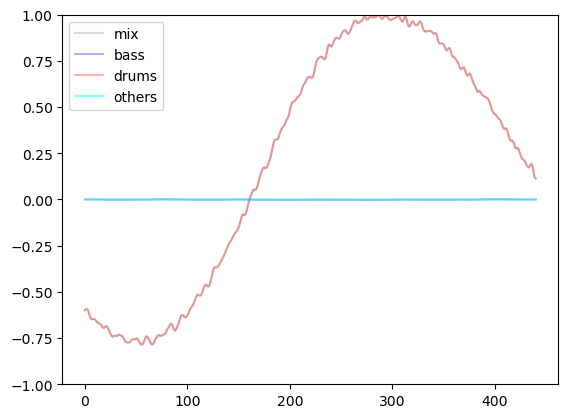

torch.Size([100, 441, 3])


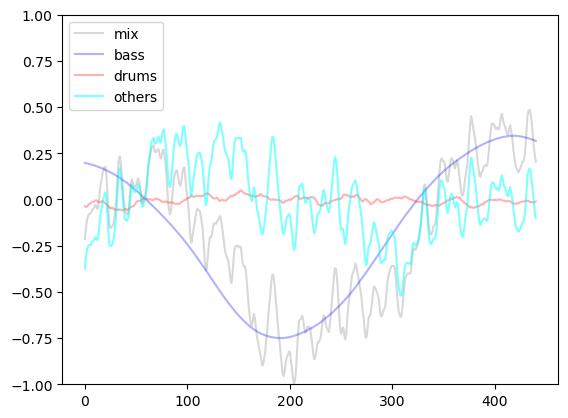

torch.Size([100, 441, 3])


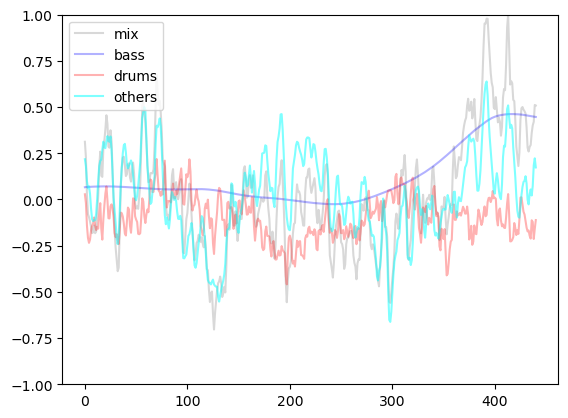

torch.Size([100, 441, 3])


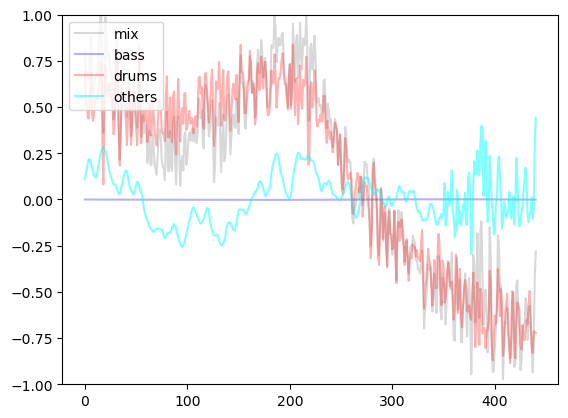

torch.Size([100, 441, 3])


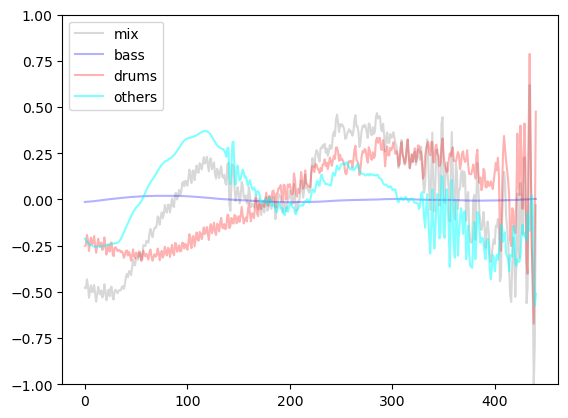

torch.Size([100, 441, 3])


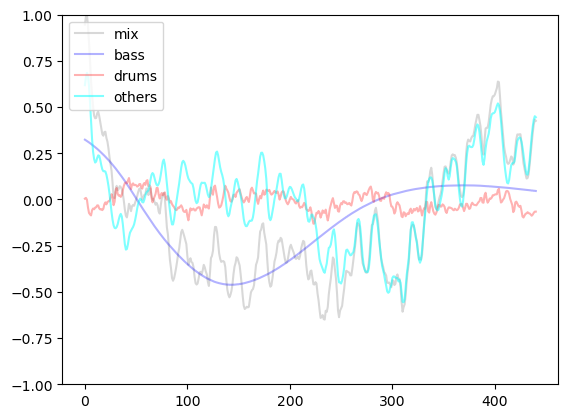

torch.Size([100, 441, 3])


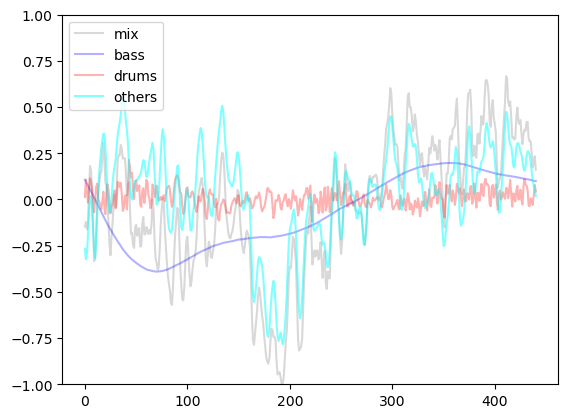

torch.Size([100, 441, 3])


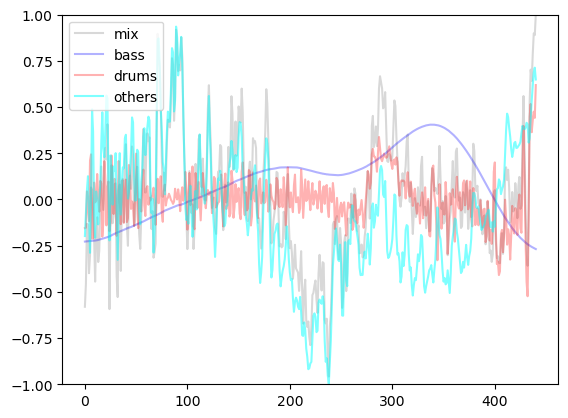

torch.Size([100, 441, 3])


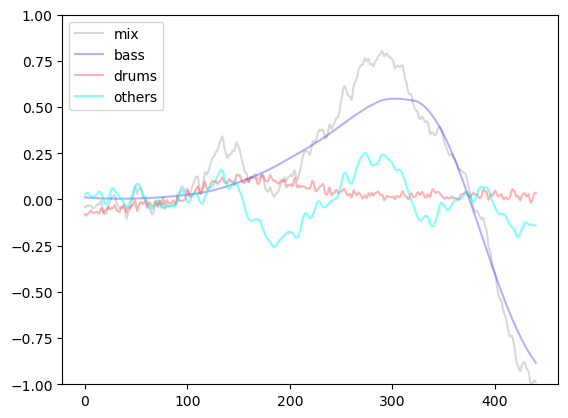

torch.Size([100, 441, 3])


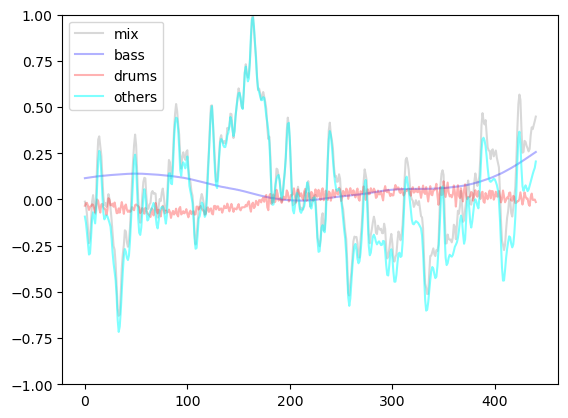

torch.Size([100, 441, 3])


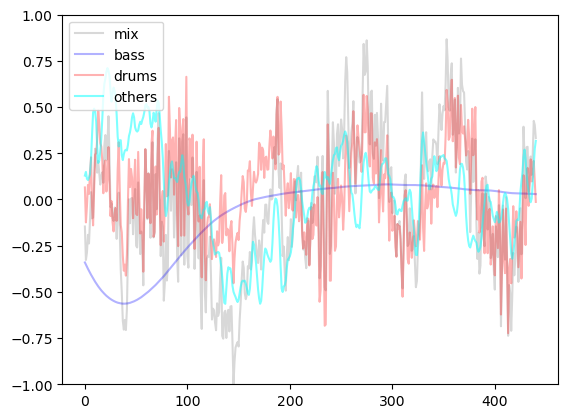

torch.Size([100, 441, 3])


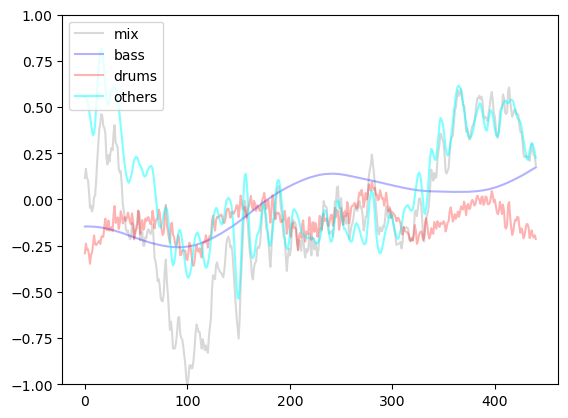

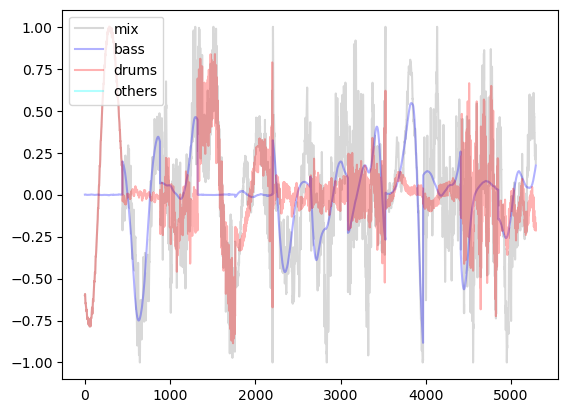

<Figure size 640x480 with 0 Axes>

In [7]:
    device = 'cpu'
    mixes_plt_tot = torch.tensor([])
    bass_plt_tot = torch.tensor([])
    drums_plt_tot = torch.tensor([])
    other_plt_tot = torch.tensor([])
    for i, data in enumerate(dataloader):
        if i > 11: break
        # print(i, data[0].shape, data[1][0].shape, data[1][1].shape)
#         print(data[0])
        mixes_uncut = data[0].to(device)
        sources_uncut = list(map(lambda x: x.to(device), data[1]))
        mixes = mixes_uncut
        sources = []
        for tensors in sources_uncut:
            tensor_seg = tensors
            sources.append(tensor_seg)
            
        mixes_lstm = mixes.unsqueeze(-1).float() # make dimension from (batch size, seq len) to (batch size, seq len, num of input)

        max_mix, _ = torch.max(torch.abs(mixes_lstm), dim=1, keepdims=True)

        mixes_lstm_norm = torch.div(mixes_lstm, max_mix)
        mixes_lstm_norm = torch.nan_to_num(mixes_lstm_norm, nan=0.0)# switch nan to zero
        # mixes_lstm_norm = mixes_lstm #log scale

        # sources_lstm = torch.stack([sources[0], sources[1], sources[2], sources[3]], dim=-1).float()
        # sources_lstm = torch.stack([sources[0], sources[1]], dim=-1).float()
        sources_lstm = torch.stack([sources[0], sources[1], sources[2]], dim=-1).float()
        

        sources_lstm_norm = torch.div(sources_lstm, max_mix)
        sources_lstm_norm = torch.nan_to_num(sources_lstm_norm, nan=0.0)# switch nan to zero
        # sources_lstm_norm = sources_lstm #log scale
        print(sources_lstm_norm.shape)
        
        # print(i, mixes_lstm_norm.shape, sources_lstm_norm.shape)
        
        mixes_plt  = mixes_lstm_norm[0,:,0].clone().detach().cpu()
        bass_plt   = sources_lstm_norm[0,:,0].clone().detach().cpu()
        drums_plt  = sources_lstm_norm[0,:,1].clone().detach().cpu()
        # vocals_plt = sources_lstm_norm[0,:,2].clone().detach().cpu()
        other_plt  = sources_lstm_norm[0,:,2].clone().detach().cpu()
    
        mixes_plt_tot = torch.cat((mixes_plt_tot, mixes_plt))
        bass_plt_tot = torch.cat((bass_plt_tot, bass_plt))
        drums_plt_tot = torch.cat((drums_plt_tot, drums_plt))
        plt.plot(mixes_plt, label='mix', color='gray', alpha=0.3)# plot the 0th batch
        plt.plot(bass_plt, label='bass', color='blue', alpha=0.3)
        plt.plot(drums_plt, label='drums', color='red', alpha=0.3)
        # plt.plot(vocals_plt, label='vocals', color='magenta', alpha=0.5)
        plt.plot(other_plt, label='others', color='cyan', alpha=0.5)
        plt.ylim([-1, 1])
        plt.legend(loc='upper left')
        plt.show()
        plt.clf()
    plt.plot(mixes_plt_tot, label='mix', color='gray', alpha=0.3)
    plt.plot(bass_plt_tot, label='bass', color='blue', alpha=0.3)
    plt.plot(drums_plt_tot, label='drums', color='red', alpha=0.3)
    plt.plot(other_plt_tot, label='others', color='cyan', alpha=0.3)
    plt.legend(loc='upper left')
    plt.show()
    plt.clf()

In [8]:
    audios = readaudio.__getitem__(1, 44100)
    # dataloader = DataLoader(audios, batch_size=441, shuffle=False, persistent_workers=True, num_workers=8, pin_memory=True)
    dataloader = DataLoader(audios, batch_size=1)#, shuffle=False, persistent_workers=False, num_workers=8, pin_memory=True)
    

READING AUDIOS not in LOGSCALE
0
mix len:  7920084


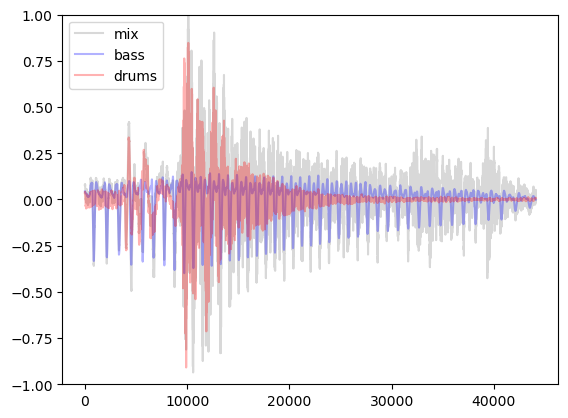

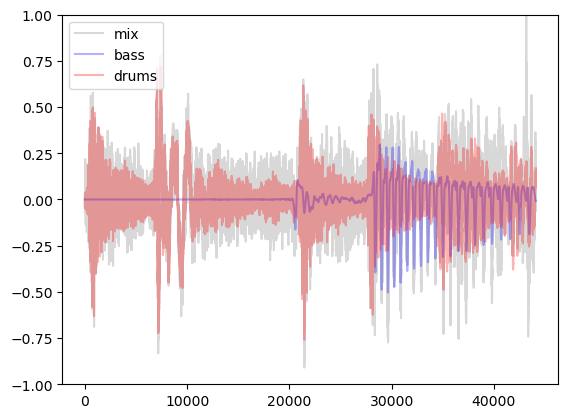

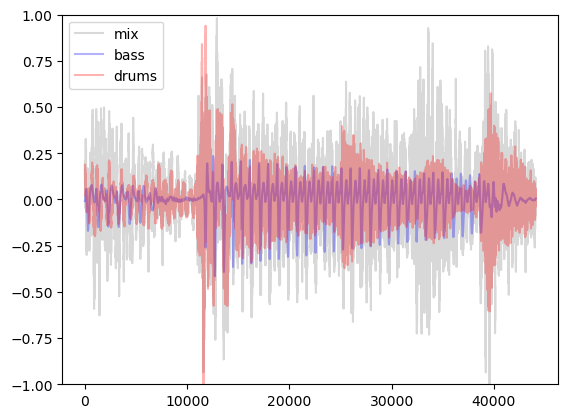

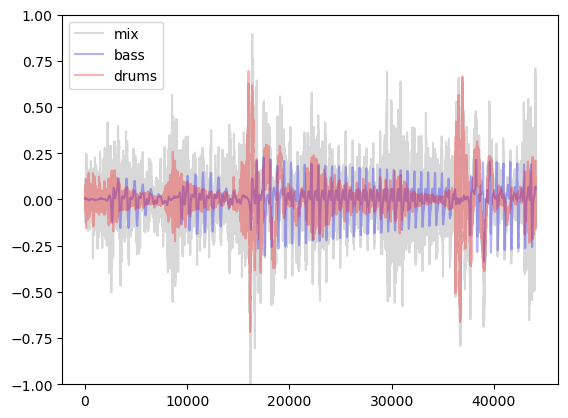

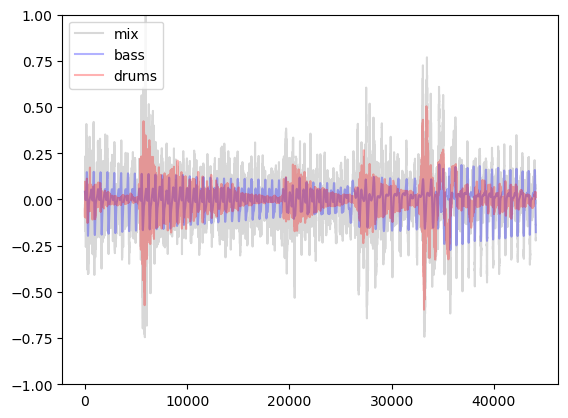

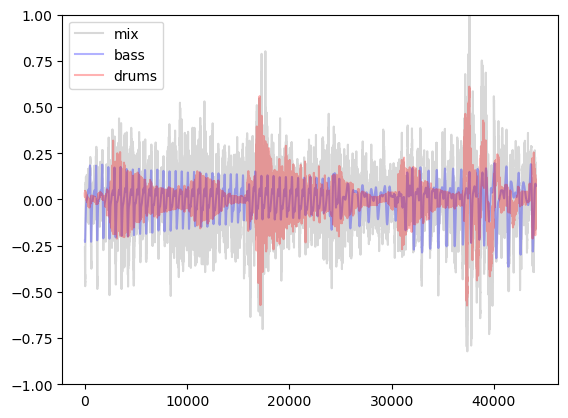

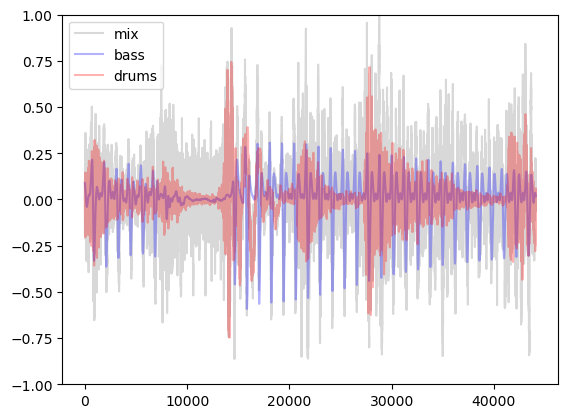

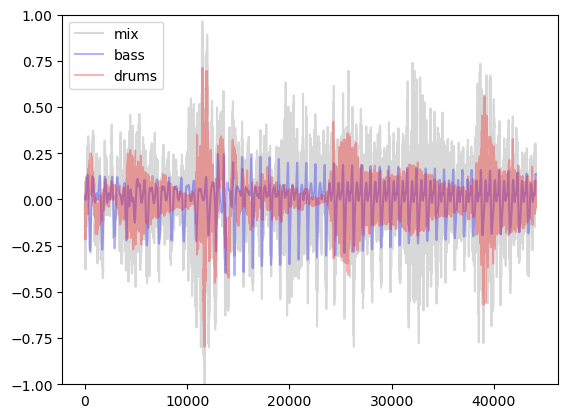

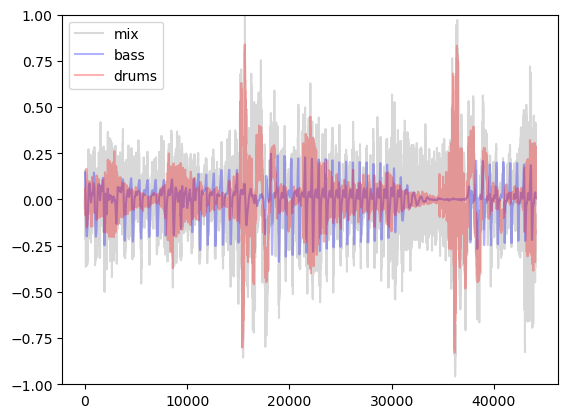

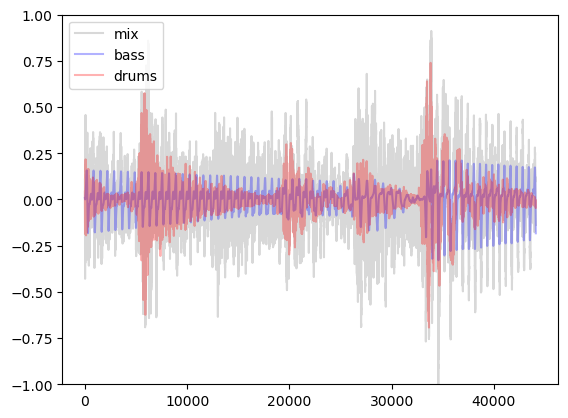

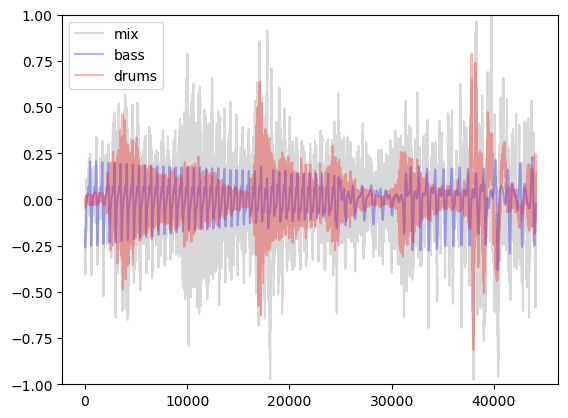

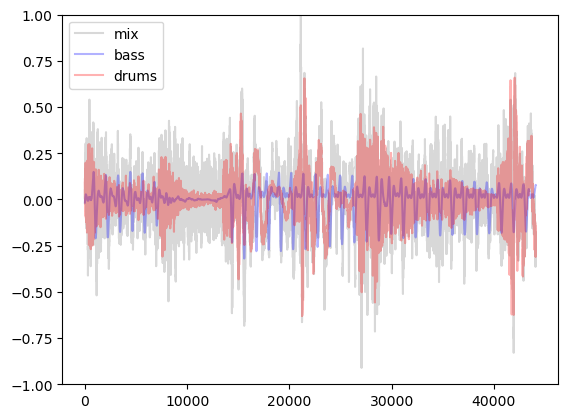

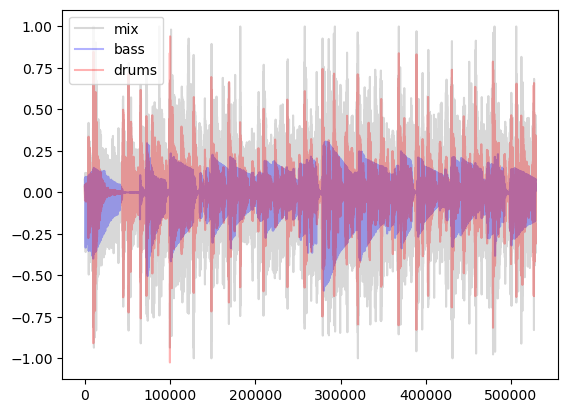

<Figure size 640x480 with 0 Axes>

In [9]:
    device = 'cpu'
    mixes_plt_tot = torch.tensor([])
    bass_plt_tot = torch.tensor([])
    drums_plt_tot = torch.tensor([])
    for i, data in enumerate(dataloader):
        if i > 11: break
        # print(i, data[0].shape, data[1][0].shape, data[1][1].shape)
#         print(data[0])
        mixes_uncut = data[0].to(device)
        sources_uncut = list(map(lambda x: x.to(device), data[1]))
        mixes = mixes_uncut
        sources = []
        for tensors in sources_uncut:
            tensor_seg = tensors
            sources.append(tensor_seg)
            
        mixes_lstm = mixes.unsqueeze(-1).float() # make dimension from (batch size, seq len) to (batch size, seq len, num of input)

        max_mix, _ = torch.max(torch.abs(mixes_lstm), dim=1, keepdims=True)
        mixes_lstm_norm = torch.div(mixes_lstm, max_mix)
        mixes_lstm_norm = torch.nan_to_num(mixes_lstm_norm, nan=0.0)# switch nan to zero

        # sources_lstm = torch.stack([sources[0], sources[1], sources[2], sources[3]], dim=-1).float()
        sources_lstm = torch.stack([sources[0], sources[1]], dim=-1).float()
        sources_lstm_norm = torch.div(sources_lstm, max_mix)
        sources_lstm_norm = torch.nan_to_num(sources_lstm_norm, nan=0.0)# switch nan to zero

        # print(i, mixes_lstm_norm.shape, sources_lstm_norm.shape)
        
        mixes_plt  = mixes_lstm_norm[0,:,0].clone().detach().cpu()
        bass_plt   = sources_lstm_norm[0,:,0].clone().detach().cpu()
        drums_plt  = sources_lstm_norm[0,:,1].clone().detach().cpu()
        # vocals_plt = sources_lstm_norm[0,:,2].clone().detach().cpu()
        # other_plt  = sources_lstm_norm[0,:,3].clone().detach().cpu()
    
        mixes_plt_tot = torch.cat((mixes_plt_tot, mixes_plt))
        bass_plt_tot = torch.cat((bass_plt_tot, bass_plt))
        drums_plt_tot = torch.cat((drums_plt_tot, drums_plt))
        plt.plot(mixes_plt, label='mix', color='gray', alpha=0.3)# plot the 0th batch
        plt.plot(bass_plt, label='bass', color='blue', alpha=0.3)
        plt.plot(drums_plt, label='drums', color='red', alpha=0.3)
        # plt.plot(vocals_plt, label='vocals', color='magenta', alpha=0.5)
        # plt.plot(other_plt, label='others', color='cyan', alpha=0.5)
        plt.ylim([-1, 1])
        plt.legend(loc='upper left')
        plt.show()
        plt.clf()
    plt.plot(mixes_plt_tot, label='mix', color='gray', alpha=0.3)
    plt.plot(bass_plt_tot, label='bass', color='blue', alpha=0.3)
    plt.plot(drums_plt_tot, label='drums', color='red', alpha=0.3)
    plt.legend(loc='upper left')
    plt.show()
    plt.clf()